In [2]:
## Standard Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Data Dictionary:

* ID  -  Unique_transaction_ID
* Item_ID  -  Unique ID of the product
* Datetime  -  Date of Sale
* Price  -  Median Price at Sale on that day(Target Variable_1)
* Number_Of_Sales  -  Total Item Sold on that day(Target Variable_2)
* Category_1  -  Unordered Masked feature
* Category_2  -  Ordered Masked feature
* Category_3  -  Binary Masked feature

In [3]:
training_df = pd.read_csv("train.csv")
training_df.head(10)

,ID,Item_ID,Datetime,Category_3,Category_2,Category_1,Price,Number_Of_Sales
0,30495_20140101,30495,2014-01-01,0,2.0,90,165.123,1
1,30375_20140101,30375,2014-01-01,0,2.0,307,68.666,5
2,30011_20140101,30011,2014-01-01,0,3.0,67,253.314,2
3,30864_20140101,30864,2014-01-01,0,2.0,315,223.122,1
4,30780_20140101,30780,2014-01-01,1,2.0,132,28.750,1
5,30927_20140101,30927,2014-01-01,0,1.0,38,4.345,402
6,31342_20140101,31342,2014-01-01,0,2.0,38,2.874,832
7,30540_20140101,30540,2014-01-01,0,3.0,38,3.123,423
8,29999_20140101,29999,2014-01-01,0,3.0,67,7.286,133
9,30068_20140101,30068,2014-01-01,0,2.0,195,0.843,375


In [4]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881876 entries, 0 to 881875
Data columns (total 8 columns):
ID                 881876 non-null object
Item_ID            881876 non-null int64
Datetime           881876 non-null object
Category_3         881876 non-null int64
Category_2         790263 non-null float64
Category_1         881876 non-null int64
Price              881876 non-null float64
Number_Of_Sales    881876 non-null int64
dtypes: float64(2), int64(4), object(2)
memory usage: 53.8+ MB


In [5]:
training_df.describe()

,Item_ID,Category_3,Category_2,Category_1,Price,Number_Of_Sales
count,881876.000000,881876.000000,790263.000000,881876.000000,881876.000000,881876.000000
mean,30517.396677,0.162506,2.755723,186.923135,5.484011,1201.021046
std,487.892582,0.368914,1.263769,130.754875,22.472598,7750.049731
min,29654.000000,0.000000,1.000000,0.000000,0.030000,1.000000
25%,30107.000000,0.000000,2.000000,70.000000,0.125000,69.000000
50%,30518.000000,0.000000,3.000000,176.000000,0.513000,239.000000
75%,30929.000000,0.000000,4.000000,307.000000,2.070000,746.000000
max,31375.000000,1.000000,5.000000,413.000000,424.148000,598054.000000


### Category 2 - Ordered masked feature has a few missing values.
### Let me check the percentage of missing values.

In [6]:
print("Percentage of available data for each parameter:")
print(training_df.count() * 100 / len(training_df))

Percentage of available data for each parameter:
ID                 100.000000
Item_ID            100.000000
Datetime           100.000000
Category_3         100.000000
Category_2          89.611578
Category_1         100.000000
Price              100.000000
Number_Of_Sales    100.000000
dtype: float64


* Datetime needs to be converted to a time-series

* Category_2 has 11% of missing values.

In [7]:
### Filling the Null values of Category_2 with median values of the column.

## I'm using the median values since its not susceptible to outliers in the column, 
## Also the trade happens based on the median value of the quoted price by both the seller and the buyer.

training_df["Category_2"] = training_df["Category_2"].fillna(training_df["Category_2"].median())

In [8]:
### Now I'm checking if there are no null values in Category_2

print("Percentage of available data for each parameter:")
print(training_df.count() * 100 / len(training_df))

Percentage of available data for each parameter:
ID                 100.0
Item_ID            100.0
Datetime           100.0
Category_3         100.0
Category_2         100.0
Category_1         100.0
Price              100.0
Number_Of_Sales    100.0
dtype: float64


### The data-set looks seems usable now with no missing values in any of the column.

### Now, I will be converting the column "Datetime" to a Time Series object 

In [9]:
# Datetime:
try:
    training_df['Datetime'] = pd.to_datetime(training_df['Datetime'])
except Exception as e:
    print(e)
    print("Please check for data points in the 'date' column that are in unacceptable format")

If the date is in any unacceptable format then the above step would fail and throw an exception.

In [10]:
## Setting Datetime as the index

training_df = training_df.set_index('Datetime', drop=True)

### Data distribution

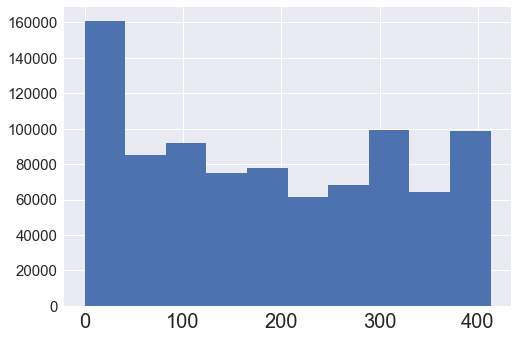

In [11]:
training_df.Category_1.hist(xlabelsize=20,ylabelsize=15)

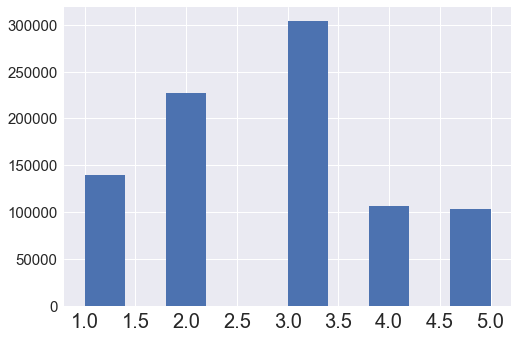

In [12]:
training_df.Category_2.hist(xlabelsize=20,ylabelsize=15)

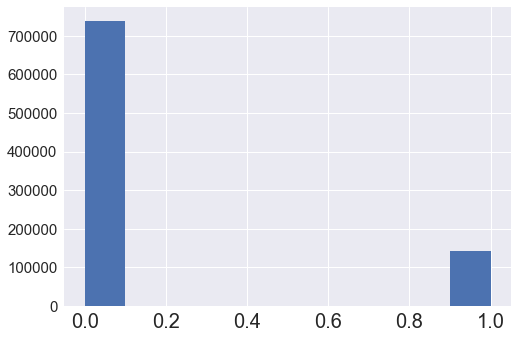

In [13]:
training_df.Category_3.hist(xlabelsize=20,ylabelsize=15)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text xticklabel objects>)

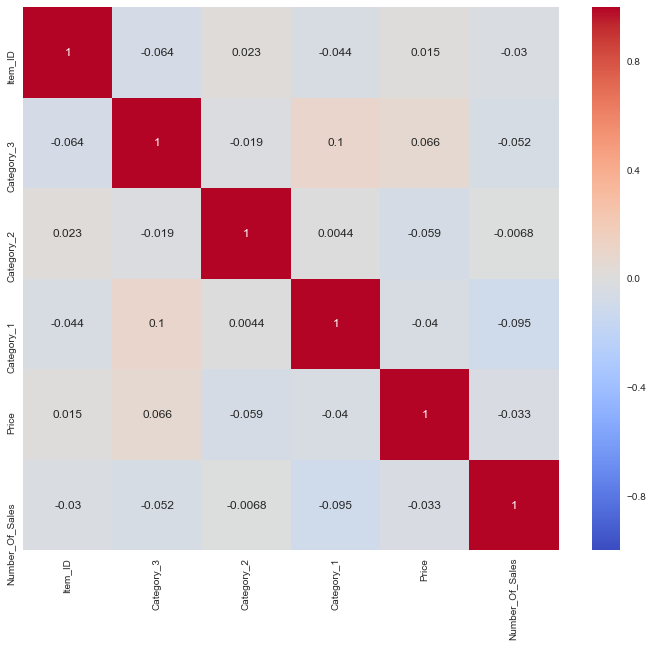

In [14]:
### Understanding the correlation between the features

corr = training_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cbar=True, cmap='coolwarm')
plt.xticks(rotation=90)

##  Observe how Category_3 has the highest correlation with Category_1 = 0.1
## Also, Category_3 has a correlation of 0.06 with the price of the product.

In [18]:
## ML Models 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB as GB
from sklearn.svm import SVC

In [22]:
def Classification_model(model,training_df,x,y): 
    train,test = train_test_split(training_df,test_size= 0.33)
    train_x = training_df.loc[train.index,x] # Data for training only with features
    train_y = training_df.loc[train.index,y] # Data for training only with predcition variable
    test_x = training_df.loc[test.index,x] 
    test_y = training_df.loc[test.index,y]
    
    model.fit(train_x,train_y.values.ravel())
    
    pred=model.predict(test_x)
    
    accuracy=accuracy_score(test_y,pred)
    return accuracy

In [23]:
Features = ['Category_1',
'Category_2',
'Category_3']

#Target Variable
Pred_var = ["Number_Of_Sales", "Price"]

In [24]:
models=["RandomForestClassifier","Gaussian Naive Bays","KNN","Logistic_Regression","Support_Vector"]
Classification_models = [RandomForestClassifier(n_estimators=100),GB(),knn(n_neighbors=7),LogisticRegression(),SVC()]
Model_Accuracy = []
for model in Classification_models:
    Accuracy=Classification_model(model,training_df,Features,Pred_var)
    Model_Accuracy.append(Accuracy)

KeyboardInterrupt: 